In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

import text_utilities
import deep_learning_utils

from collections import Counter
import os
import random
import re
import string
import time

seed = 2137

random.seed = seed
tf.random.set_seed(seed)
np.random.seed(seed)

2024-05-28 10:13:49.466565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset Import

In [2]:
dataset_path = os.path.join('data/articles', 'articles_23-05-2024_12h13m03s.csv')

df = pd.read_csv(dataset_path)

In [3]:
df['full_text'] = df['title'] + ' ' + df['summary']

In [4]:
df = df.dropna(subset=['full_text'])
df = df.dropna(subset='relevant')

In [5]:
df['full_text_clean'] = text_utilities.text_cleaning_pd_series(df['full_text'], lemmatization=True)

In [6]:
data = df[['full_text_clean', 'relevant']].copy()

data['relevant'] = data['relevant'].apply(lambda x: 1 if x == True else 0)

data.dropna(inplace=True)

In [7]:
train, test = train_test_split(data, test_size=0.2, random_state=seed, shuffle=True, stratify=data['relevant'])

train, val = train_test_split(train, test_size=0.2, random_state=seed, shuffle=True, stratify=train['relevant'])

## Tensorflow Dataset Creation

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train['full_text_clean'].values, train['relevant'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val['full_text_clean'].values, val['relevant'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test['full_text_clean'].values, test['relevant'].values))

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

 ## Optimize the Dataset

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Modeling

## Modeling Utilities

In [10]:
output_dim = 256

vocab_size = 22000

def custom_standardization(input_text):
    """Lowercase and remove punctuation from the text."""
    lowercase_text = tf.strings.lower(input_text)
    cleaned_text = tf.strings.regex_replace(lowercase_text, '[%s]' % re.escape(string.punctuation), '')
    return cleaned_text

# Create the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=output_dim,
    standardize=custom_standardization
)

# Assuming `texts` is a list or dataset of your text data
vectorize_layer.adapt(train['full_text_clean'])

In [11]:
metrics = ['accuracy', 'recall', 'precision', 'AUC']

epochs=20

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)

## Model Registry

In [14]:
path_to_registry = r'model_results_table.csv'

if os.path.exists(path_to_registry):
    model_registry = pd.read_csv(path_to_registry, index_col=0).reset_index(drop=False)
else:
    model_registry = None

## RNN Models with Embeddings

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - AUC: 0.5610 - accuracy: 0.5608 - loss: 0.6736 - precision: 0.4532 - recall: 0.2182 - val_AUC: 0.7121 - val_accuracy: 0.6730 - val_loss: 0.6235 - val_precision: 0.6635 - val_recall: 0.4452
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - AUC: 0.7699 - accuracy: 0.7015 - loss: 0.5897 - precision: 0.7329 - recall: 0.4332 - val_AUC: 0.7601 - val_accuracy: 0.6703 - val_loss: 0.5961 - val_precision: 0.7797 - val_recall: 0.2968
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - AUC: 0.8244 - accuracy: 0.7432 - loss: 0.5269 - precision: 0.7922 - recall: 0.5292 - val_AUC: 0.8150 - val_accuracy: 0.6919 - val_loss: 0.5674 - val_precision: 0.7887 - val_recall: 0.3613
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - AUC: 0.8714 - accuracy: 0.7871 - loss: 0.4549 - precision: 0.7802 - recall: 0.6832 - val_AUC: 0.8696 - val_accuracy: 0.7946 - val_loss: 0.4518 - val_precision: 0.7548 - val_recall: 0

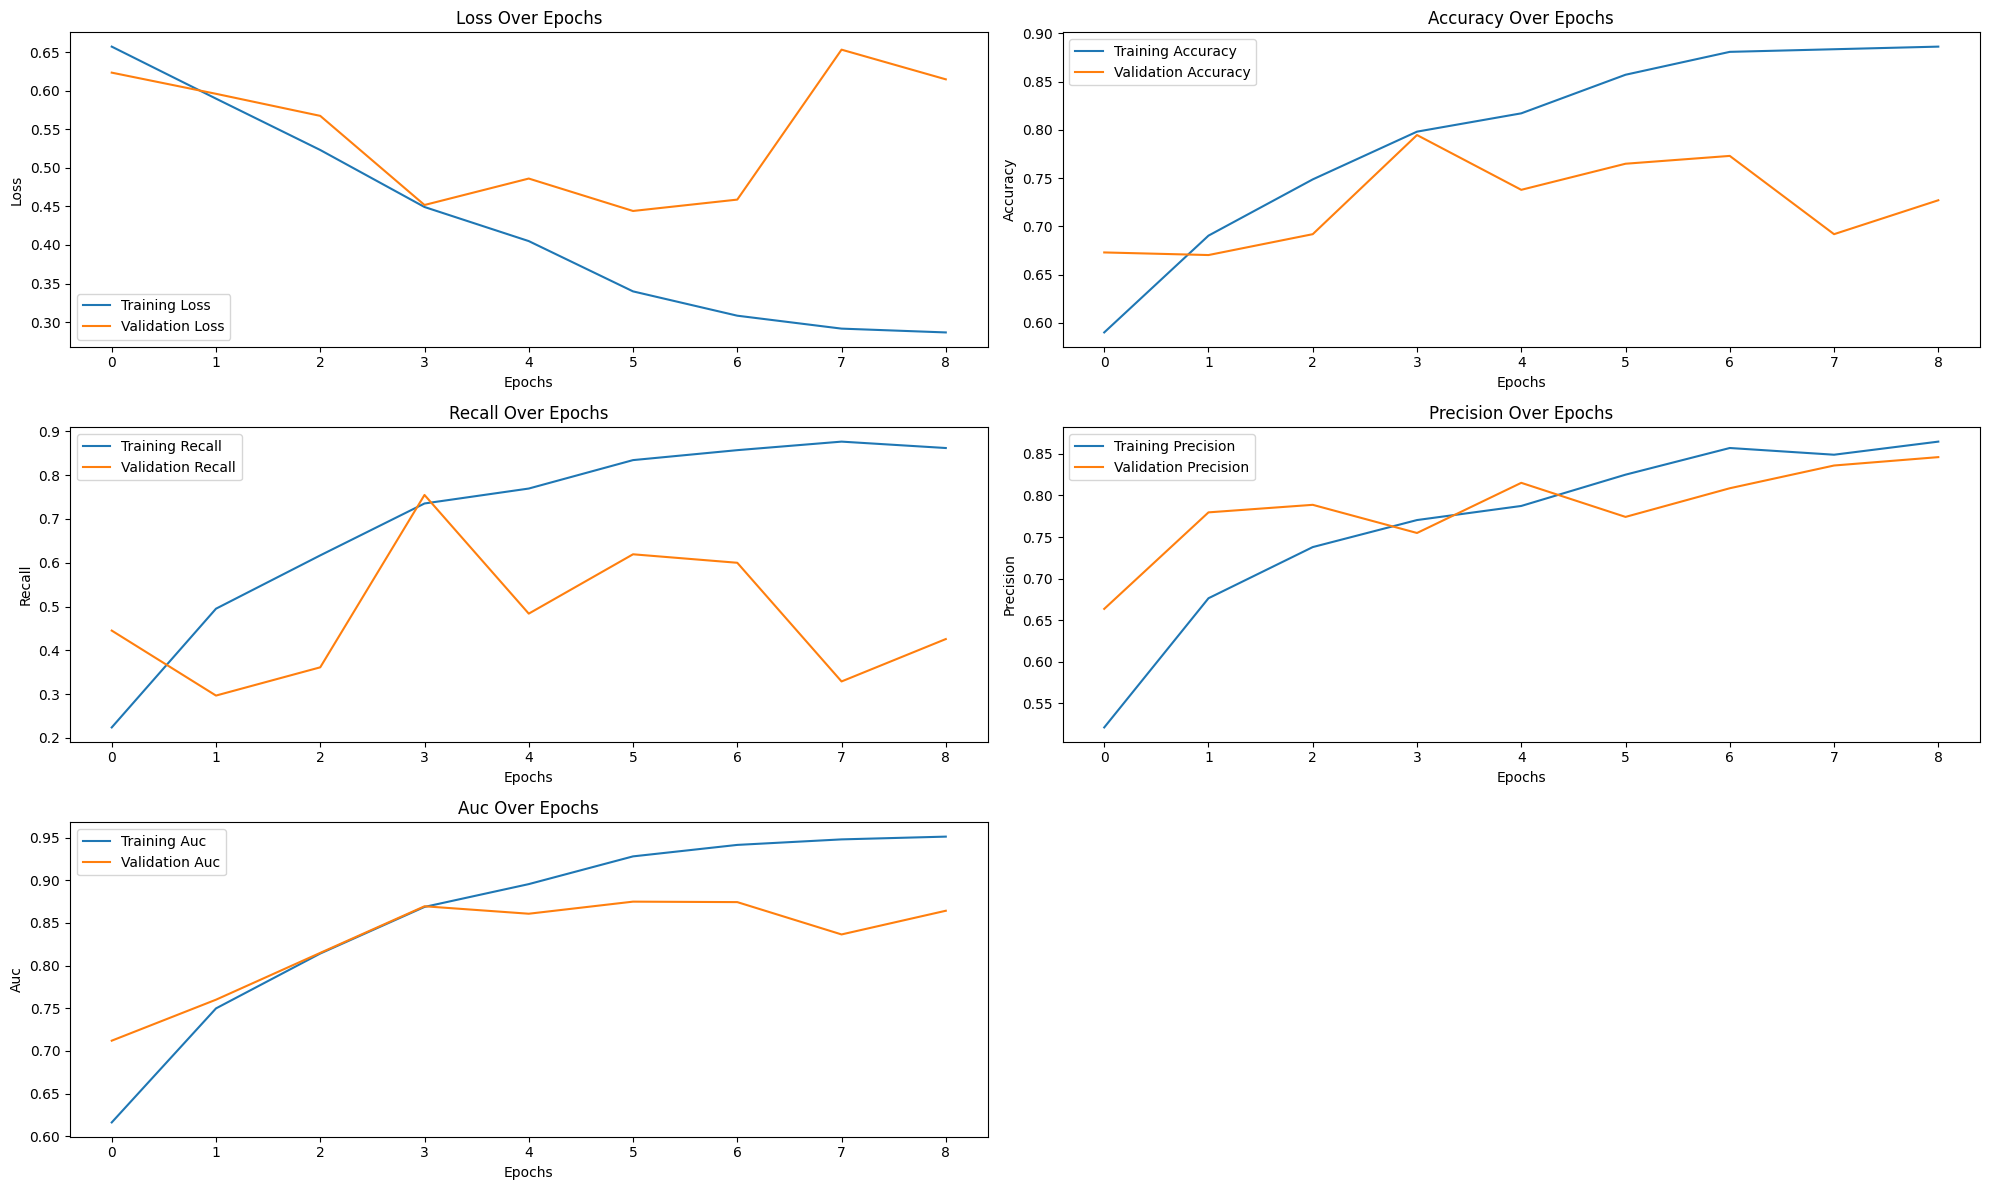


Final Training Loss: 0.2865
Final Validation Loss: 0.6148

Final Training Accuracy: 0.8862
Final Validation Accuracy: 0.7270

Final Training Recall: 0.8620
Final Validation Recall: 0.4258

Final Training Precision: 0.8648
Final Validation Precision: 0.8462

Final Training Auc: 0.9512
Final Validation Auc: 0.8643


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8024 - accuracy: 0.7154 - loss: 0.5329 - precision: 0.6838 - recall: 0.5948
{'AUC': 0.8110734224319458, 'accuracy': 0.7337662577629089, 'loss': 0.5260695219039917, 'precision': 0.7083333134651184, 'recall': 0.6165803074836731}
Test Loss: 0.5260695219039917
Test Accuracy: 0.7337662577629089
Test Recall: 0.6165803074836731
Test Precision: 0.7083333134651184
Test Auc: 0.8110734224319458


In [13]:
model_lstm_emb = deep_learning_utils.lstm_embeddings_creation(
    vectorize_layer=vectorize_layer,
    embedding_name='glove-wiki-gigaword-200',  # Pre-trained embedding name
    lstm_units=32,          # Number of neurons in the LSTM layer
    num_lstm_layers=1,      # Number of LSTM layers
    num_classes=1,          # Number of output classes
    seed=seed,                # Seed for reproducibility
    dropout_rate=0.0,       # No dropout
    l2_lambda=0.0,          # No L2 regularization
    metrics=metrics,   # Evaluation metrics
    batch_normalization=False  # No batch normalization
)


model_description = 'LSTM with pre-trained embeddings (wiki gigaword 200), No Regularisation'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_emb,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### One Layer LSTM with Regularisation

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - AUC: 0.5548 - accuracy: 0.5833 - loss: 0.8566 - precision: 0.5097 - recall: 0.2655 - val_AUC: 0.7078 - val_accuracy: 0.6676 - val_loss: 0.7739 - val_precision: 0.6667 - val_recall: 0.4129
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - AUC: 0.7375 - accuracy: 0.6797 - loss: 0.7433 - precision: 0.7114 - recall: 0.3731 - val_AUC: 0.7466 - val_accuracy: 0.6811 - val_loss: 0.7141 - val_precision: 0.7467 - val_recall: 0.3613
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - AUC: 0.7988 - accuracy: 0.7344 - loss: 0.6640 - precision: 0.7819 - recall: 0.5059 - val_AUC: 0.7939 - val_accuracy: 0.6784 - val_loss: 0.6846 - val_precision: 0.7903 - val_recall: 0.3161
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - AUC: 0.8469 - accuracy: 0.7614 - loss: 0.5945 - precision: 0.7691 - recall: 0.6210 - val_AUC: 0.8525 - val_accuracy: 0.7838 - val_loss: 0.5806 - val_precision: 0.7551 - val_recall: 0.71

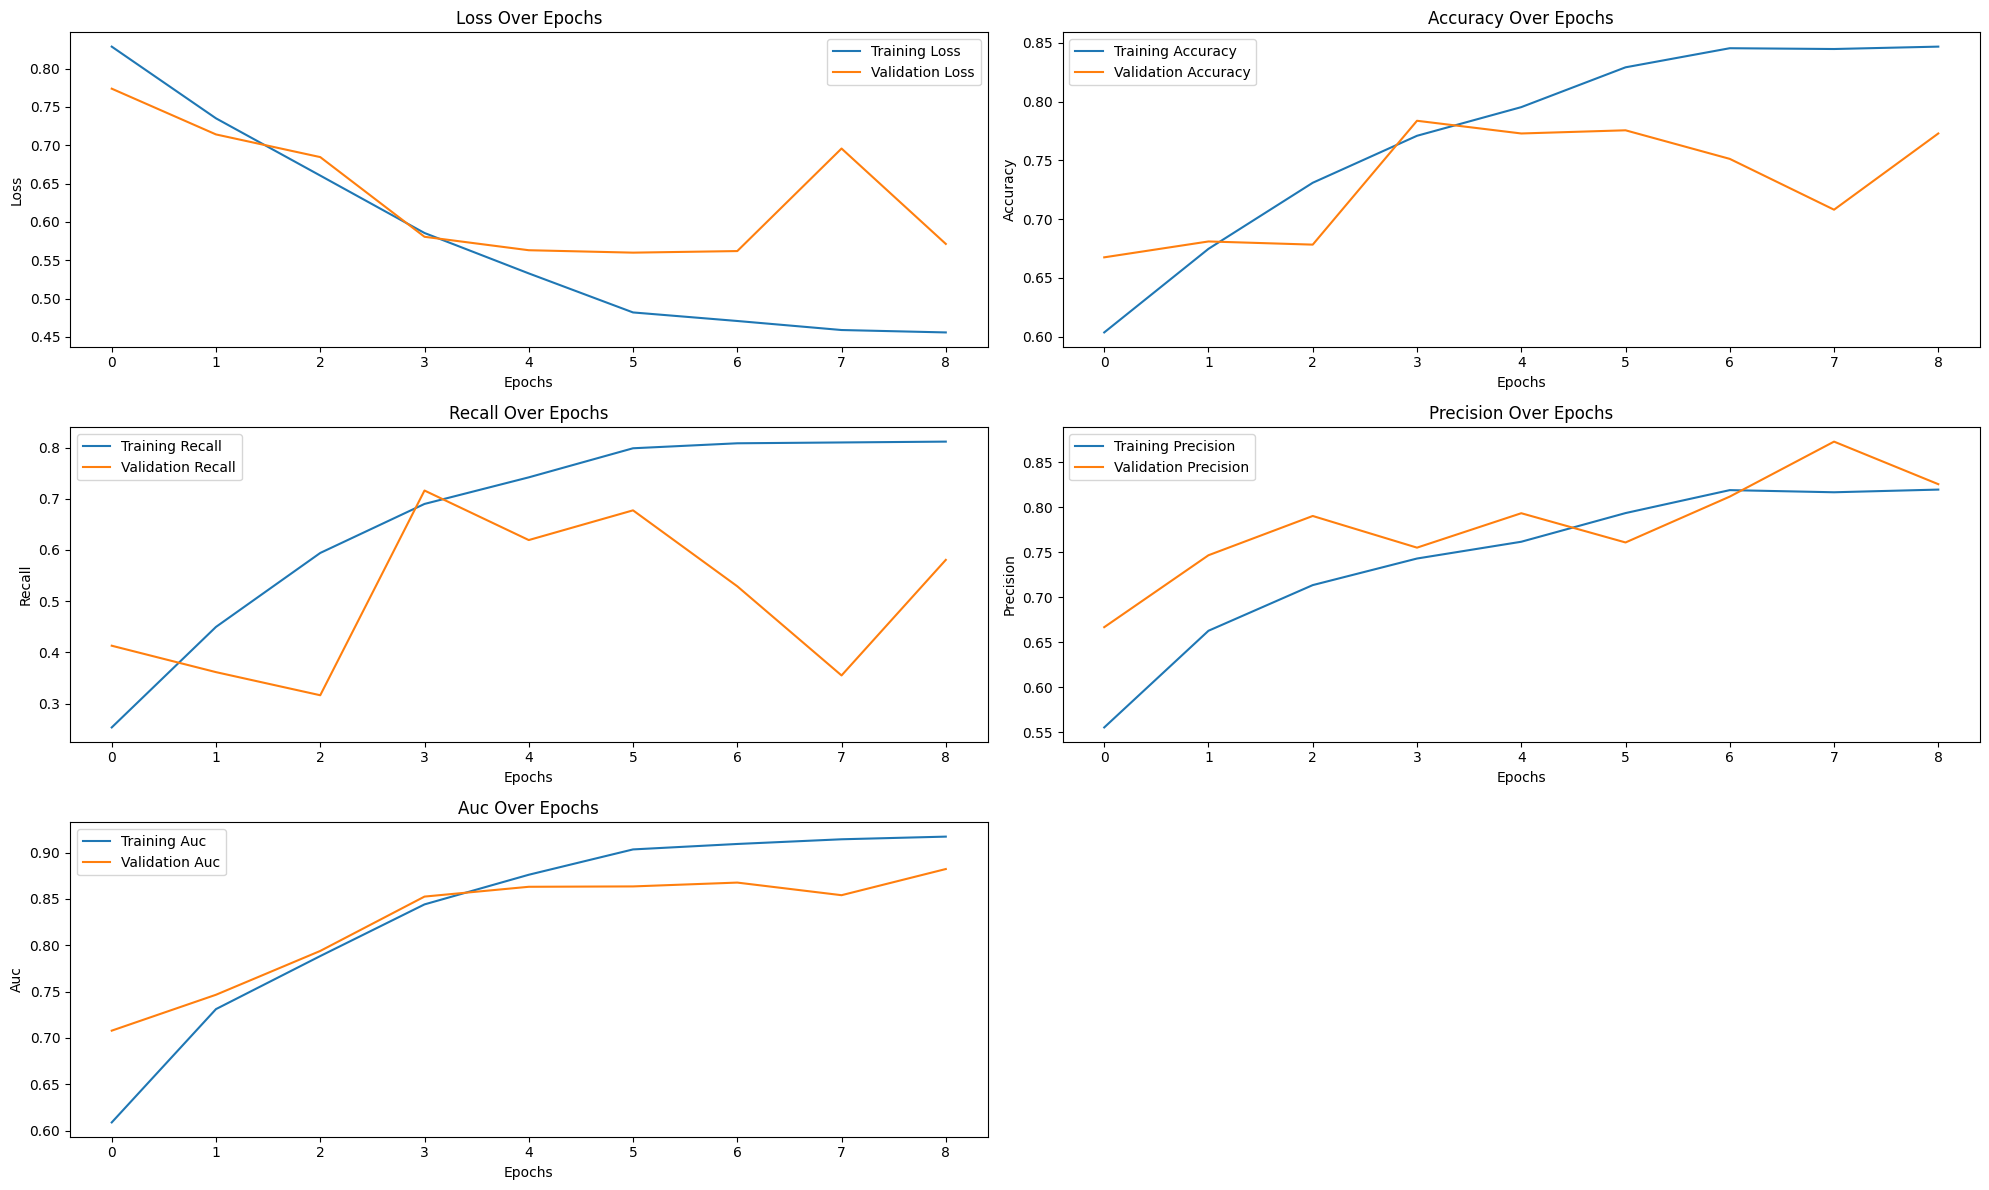


Final Training Loss: 0.4557
Final Validation Loss: 0.5713

Final Training Accuracy: 0.8469
Final Validation Accuracy: 0.7730

Final Training Recall: 0.8117
Final Validation Recall: 0.5806

Final Training Precision: 0.8197
Final Validation Precision: 0.8257

Final Training Auc: 0.9172
Final Validation Auc: 0.8823


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.7968 - accuracy: 0.7005 - loss: 0.6246 - precision: 0.6716 - recall: 0.5550
{'AUC': 0.8029065132141113, 'accuracy': 0.7229437232017517, 'loss': 0.6209320425987244, 'precision': 0.6900584697723389, 'recall': 0.6113989353179932}
Test Loss: 0.6209320425987244
Test Accuracy: 0.7229437232017517
Test Recall: 0.6113989353179932
Test Precision: 0.6900584697723389
Test Auc: 0.8029065132141113


In [14]:
### One Layer LSTM with Regularisation

model_lstm_emb_reg = deep_learning_utils.lstm_embeddings_creation(
    vectorize_layer=vectorize_layer,
    embedding_name='glove-wiki-gigaword-200',  # Pre-trained embedding name
    lstm_units=32,          # Number of neurons in the LSTM layer
    num_lstm_layers=1,      # Number of LSTM layers
    num_classes=1,          # Number of output classes
    seed=seed,                # Seed for reproducibility
    dropout_rate=0.2,       # No dropout
    l2_lambda=0.001,          # No L2 regularization
    metrics=metrics,   # Evaluation metrics
    batch_normalization=False  # No batch normalization
)

model_description = 'LSTM with pre-trained embeddings (wiki gigaword 200), Regularisation (dropoute 0.2, L2 0.001)'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_emb_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - AUC: 0.5423 - accuracy: 0.5528 - loss: 0.6812 - precision: 0.4384 - recall: 0.2365 - val_AUC: 0.7084 - val_accuracy: 0.6568 - val_loss: 0.6289 - val_precision: 0.6373 - val_recall: 0.4194
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - AUC: 0.7373 - accuracy: 0.7015 - loss: 0.6059 - precision: 0.7467 - recall: 0.4180 - val_AUC: 0.7522 - val_accuracy: 0.6730 - val_loss: 0.5895 - val_precision: 0.7125 - val_recall: 0.3677
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - AUC: 0.8060 - accuracy: 0.7346 - loss: 0.5424 - precision: 0.7619 - recall: 0.5273 - val_AUC: 0.8065 - val_accuracy: 0.7081 - val_loss: 0.5513 - val_precision: 0.7640 - val_recall: 0.4387
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - AUC: 0.8657 - accuracy: 0.7726 - loss: 0.4676 - precision: 0.7702 - recall: 0.6525 - val_AUC: 0.8671 - val_accuracy: 0.7865 - val_loss: 0.4644 - val_precision: 0.7375 - val_recall: 0.761

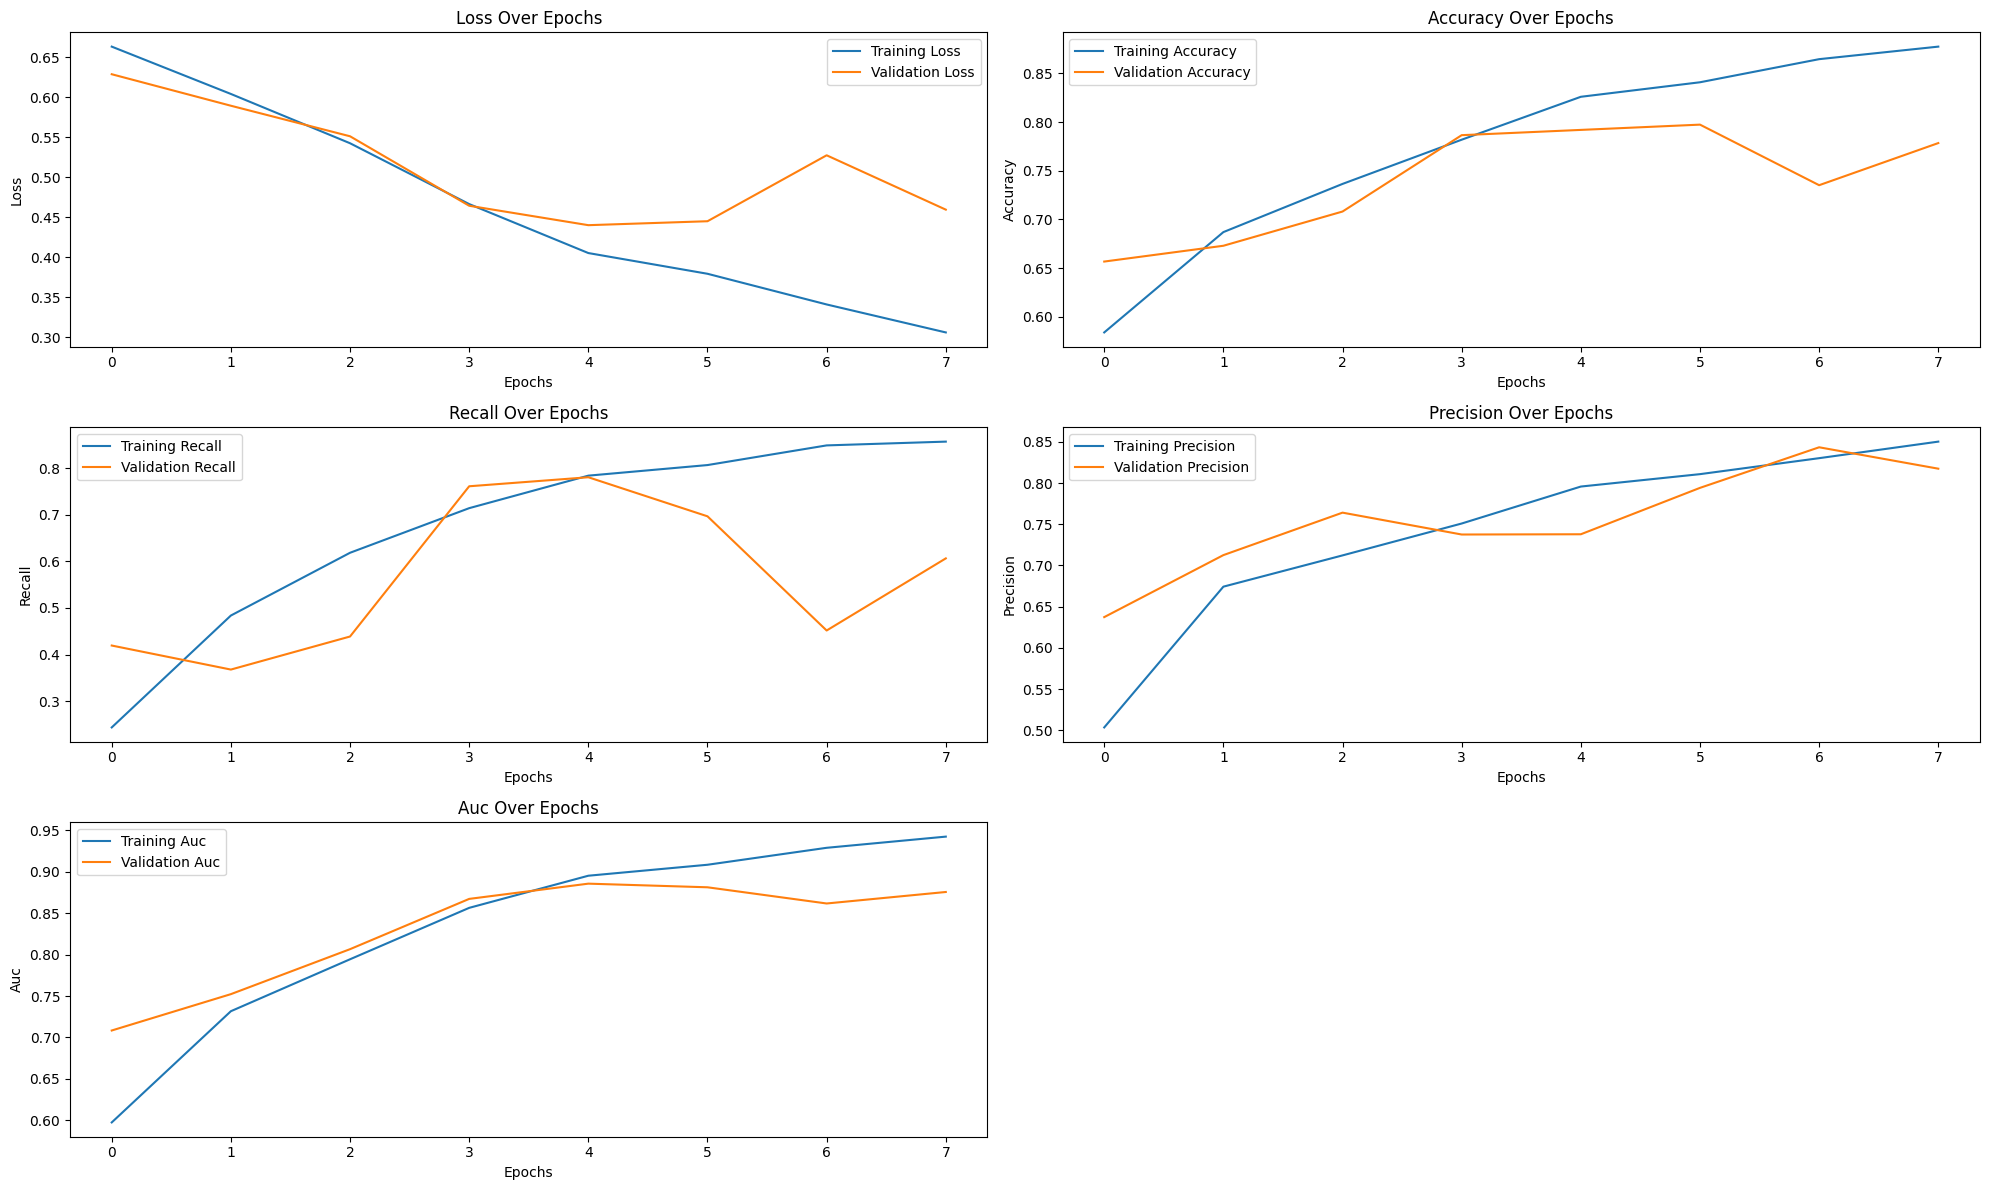


Final Training Loss: 0.3060
Final Validation Loss: 0.4595

Final Training Accuracy: 0.8774
Final Validation Accuracy: 0.7784

Final Training Recall: 0.8571
Final Validation Recall: 0.6065

Final Training Precision: 0.8502
Final Validation Precision: 0.8174

Final Training Auc: 0.9422
Final Validation Auc: 0.8755


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.8216 - accuracy: 0.7171 - loss: 0.5143 - precision: 0.6447 - recall: 0.7180
{'AUC': 0.8198856115341187, 'accuracy': 0.7294372320175171, 'loss': 0.5169242024421692, 'precision': 0.6559633016586304, 'recall': 0.7409326434135437}
Test Loss: 0.5169242024421692
Test Accuracy: 0.7294372320175171
Test Recall: 0.7409326434135437
Test Precision: 0.6559633016586304
Test Auc: 0.8198856115341187


In [15]:
### One Layer LSTM with Regularisation

model_lstm_emb_reg_2 = deep_learning_utils.lstm_embeddings_creation(
    vectorize_layer=vectorize_layer,
    embedding_name='glove-wiki-gigaword-200',  # Pre-trained embedding name
    lstm_units=32,          # Number of neurons in the LSTM layer
    num_lstm_layers=1,      # Number of LSTM layers
    num_classes=1,          # Number of output classes
    seed=seed,                # Seed for reproducibility
    dropout_rate=0.3,       # No dropout
    l2_lambda=0,          # No L2 regularization
    metrics=metrics,   # Evaluation metrics
    batch_normalization=False  # No batch normalization
)

model_description = 'LSTM with pre-trained embeddings (wiki gigaword 200), Regularisation (dropoute 0.2)'

model_registry_2 = deep_learning_utils.train_plot_and_evaluate(model_lstm_emb_reg_2,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### One Layer Bidirectional LSTM 32 Neurons

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - AUC: 0.6113 - accuracy: 0.5747 - loss: 0.6616 - precision: 0.4779 - recall: 0.1842 - val_AUC: 0.8156 - val_accuracy: 0.6973 - val_loss: 0.5650 - val_precision: 0.7792 - val_recall: 0.3871
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - AUC: 0.8717 - accuracy: 0.7914 - loss: 0.4975 - precision: 0.8453 - recall: 0.6112 - val_AUC: 0.8762 - val_accuracy: 0.7378 - val_loss: 0.4977 - val_precision: 0.8537 - val_recall: 0.4516
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - AUC: 0.9239 - accuracy: 0.8424 - loss: 0.3690 - precision: 0.8521 - recall: 0.7540 - val_AUC: 0.8890 - val_accuracy: 0.7730 - val_loss: 0.4835 - val_precision: 0.8989 - val_recall: 0.5161
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - AUC: 0.9439 - accuracy: 0.8611 - loss: 0.3162 - precision: 0.8631 - recall: 0.7913 - val_AUC: 0.8929 - val_accuracy: 0.7892 - val_loss: 0.4410 - val_precision: 0.8532 - val_recall: 

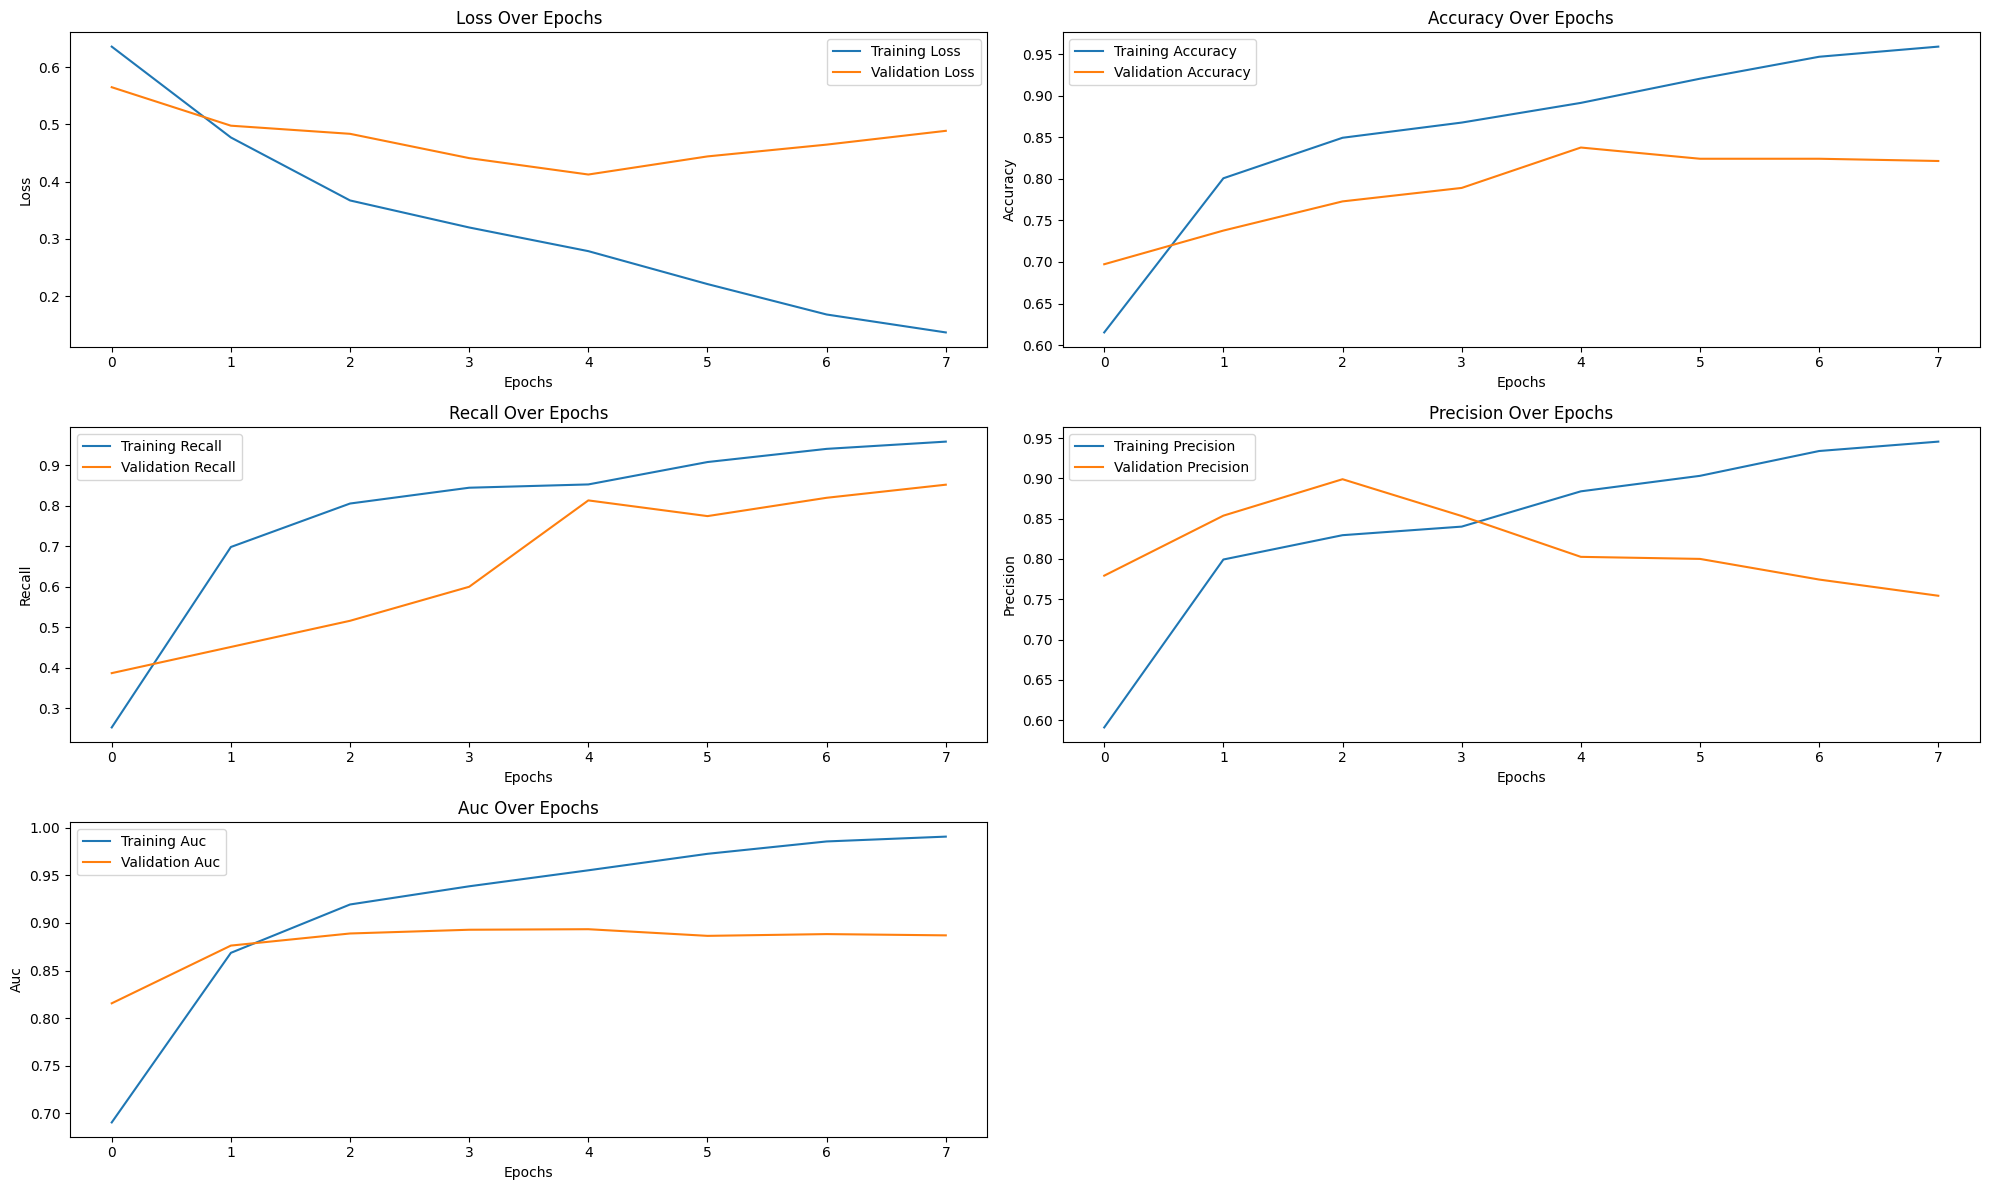


Final Training Loss: 0.1363
Final Validation Loss: 0.4887

Final Training Accuracy: 0.9593
Final Validation Accuracy: 0.8216

Final Training Recall: 0.9578
Final Validation Recall: 0.8516

Final Training Precision: 0.9455
Final Validation Precision: 0.7543

Final Training Auc: 0.9907
Final Validation Auc: 0.8870


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - AUC: 0.8720 - accuracy: 0.7778 - loss: 0.4596 - precision: 0.7232 - recall: 0.7594
{'AUC': 0.8701484799385071, 'accuracy': 0.7878788113594055, 'loss': 0.46442440152168274, 'precision': 0.7411167621612549, 'recall': 0.7564767003059387}
Test Loss: 0.46442440152168274
Test Accuracy: 0.7878788113594055
Test Recall: 0.7564767003059387
Test Precision: 0.7411167621612549
Test Auc: 0.8701484799385071


In [16]:
### One Layer Bidirectional LSTM 32 Neurons

model_lstm_emb_bidir = deep_learning_utils.lstm_embeddings_creation(
    vectorize_layer=vectorize_layer,
    embedding_name='glove-wiki-gigaword-200',  # Pre-trained embedding name
    lstm_units=32,          # Number of neurons in the LSTM layer
    num_lstm_layers=1,      # Number of LSTM layers
    num_classes=1,          # Number of output classes
    seed=seed,                # Seed for reproducibility
    dropout_rate=0.0,       # No dropout
    l2_lambda=0,          # No L2 regularization
    metrics=metrics,   # Evaluation metrics
    batch_normalization=False,  # No batch normalization
    bidirectional=True
)

model_description = 'Bidirectional LSTM with pre-trained embeddings (wiki gigaword 200)'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_emb_bidir,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Bidirectional LSTM with regularisation

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - AUC: 0.5837 - accuracy: 0.5636 - loss: 1.0159 - precision: 0.4572 - recall: 0.1891 - val_AUC: 0.7947 - val_accuracy: 0.7189 - val_loss: 0.8482 - val_precision: 0.7931 - val_recall: 0.4452
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - AUC: 0.8506 - accuracy: 0.7620 - loss: 0.7720 - precision: 0.8216 - recall: 0.5394 - val_AUC: 0.8772 - val_accuracy: 0.7432 - val_loss: 0.6821 - val_precision: 0.8261 - val_recall: 0.4903
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - AUC: 0.9161 - accuracy: 0.8369 - loss: 0.5767 - precision: 0.8275 - recall: 0.7668 - val_AUC: 0.8854 - val_accuracy: 0.7730 - val_loss: 0.6551 - val_precision: 0.8989 - val_recall: 0.5161
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - AUC: 0.9272 - accuracy: 0.8443 - loss: 0.5222 - precision: 0.8468 - recall: 0.7642 - val_AUC: 0.8875 - val_accuracy: 0.7946 - val_loss: 0.6020 - val_precision: 0.8762 - val_recall: 

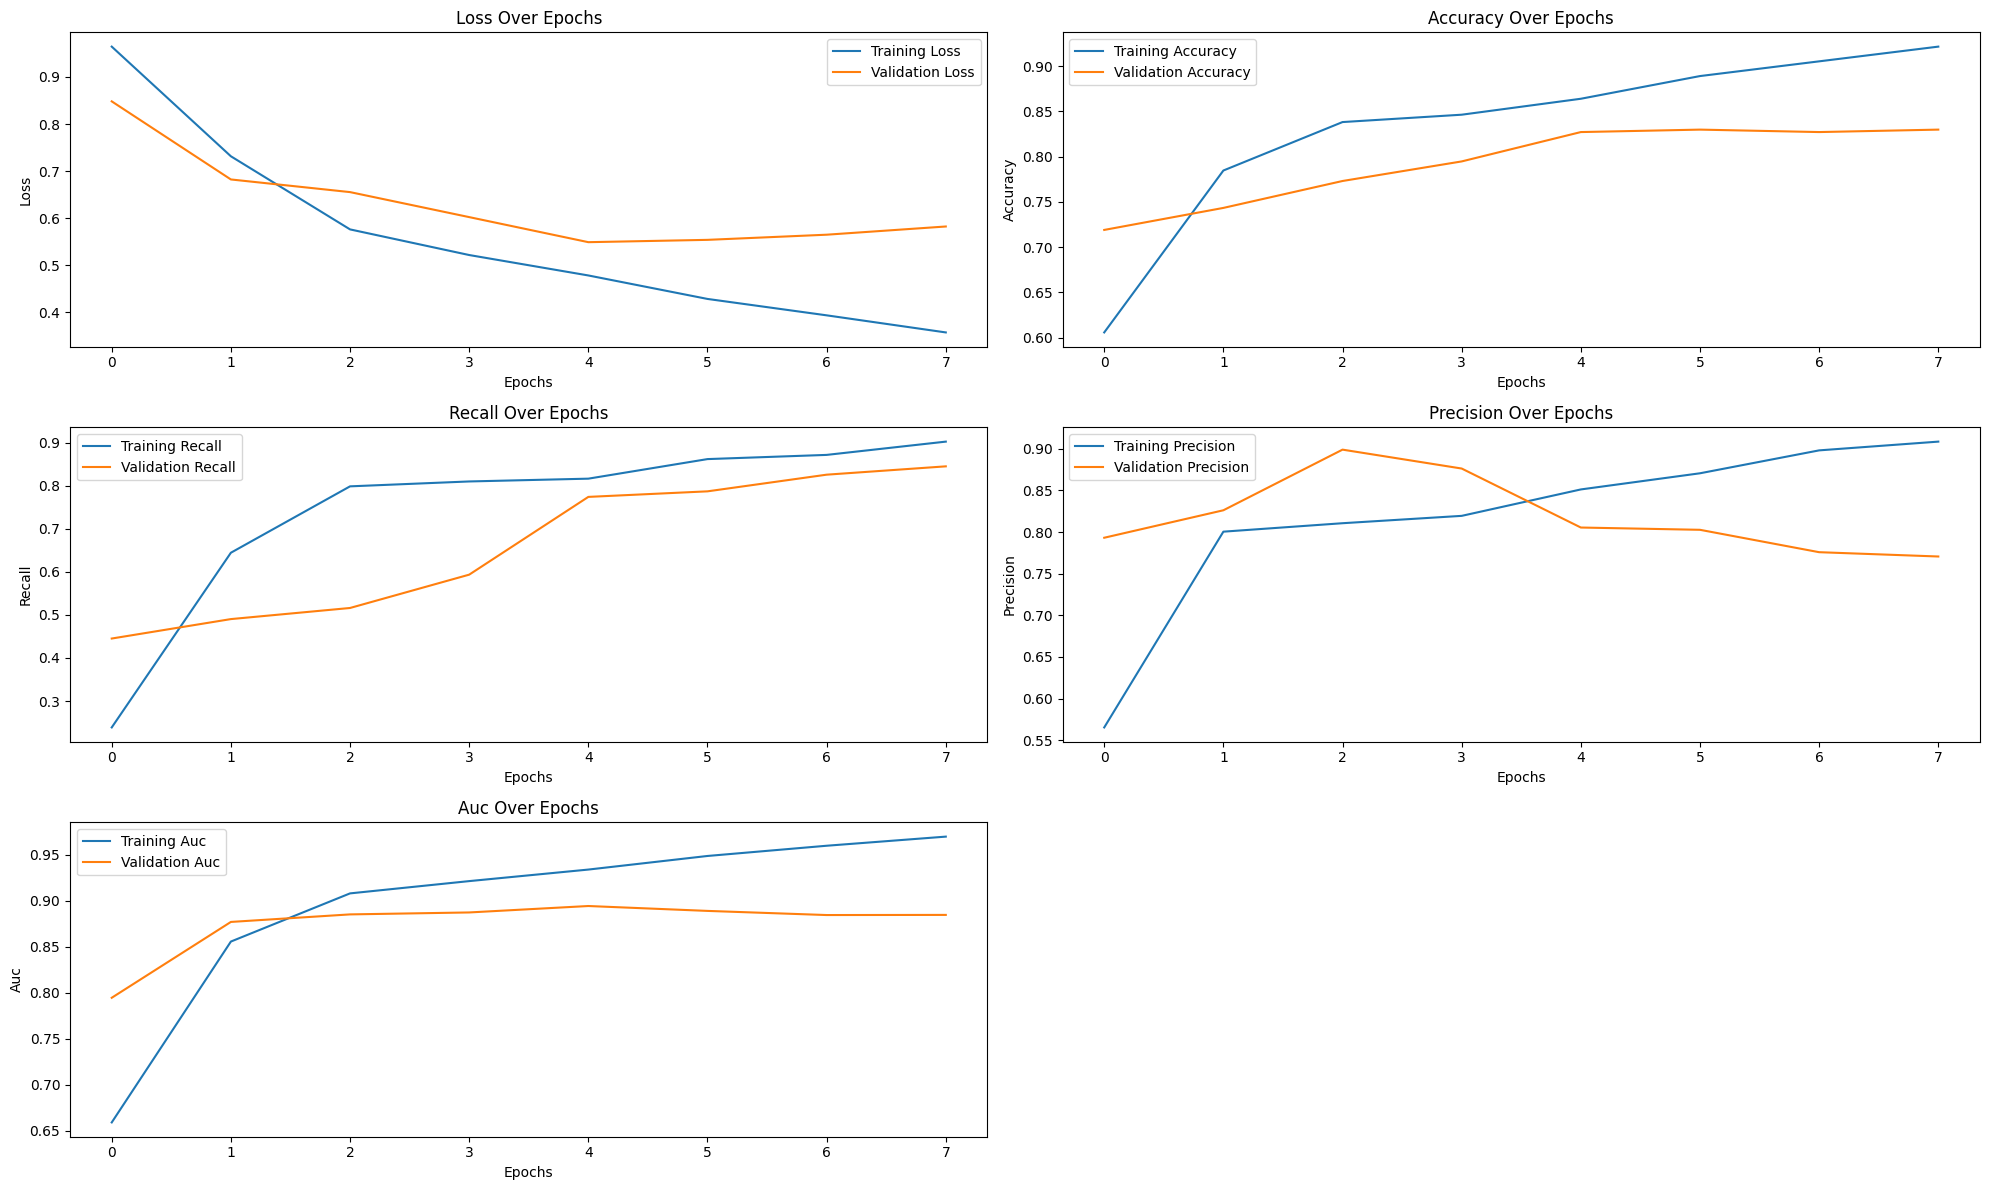


Final Training Loss: 0.3567
Final Validation Loss: 0.5820

Final Training Accuracy: 0.9214
Final Validation Accuracy: 0.8297

Final Training Recall: 0.9026
Final Validation Recall: 0.8452

Final Training Precision: 0.9085
Final Validation Precision: 0.7706

Final Training Auc: 0.9699
Final Validation Auc: 0.8848


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.8798 - accuracy: 0.7774 - loss: 0.5780 - precision: 0.7367 - recall: 0.7287
{'AUC': 0.8750312924385071, 'accuracy': 0.7878788113594055, 'loss': 0.5874052047729492, 'precision': 0.7595628499984741, 'recall': 0.7202072739601135}
Test Loss: 0.5874052047729492
Test Accuracy: 0.7878788113594055
Test Recall: 0.7202072739601135
Test Precision: 0.7595628499984741
Test Auc: 0.8750312924385071


In [17]:
### Bidirectional LSTM with regularisation

model_lstm_emb_bidir_reg = deep_learning_utils.lstm_embeddings_creation(
    vectorize_layer=vectorize_layer,
    embedding_name='glove-wiki-gigaword-200',  # Pre-trained embedding name
    lstm_units=32,          # Number of neurons in the LSTM layer
    num_lstm_layers=1,      # Number of LSTM layers
    num_classes=1,          # Number of output classes
    seed=seed,                # Seed for reproducibility
    dropout_rate=0.2,       # No dropout
    l2_lambda=0.001,          # No L2 regularization
    metrics=metrics,   # Evaluation metrics
    batch_normalization=False,  # No batch normalization
    bidirectional=True
)

model_description = 'Bidirectional LSTM with pre-trained embeddings (wiki gigaword 200), Regularisation (dropout 0.2, L2 0.001)'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_emb_bidir_reg,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Two Layer Bidirectional LSTM with 64 neurons per layer and batch normalisation

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 360ms/step - AUC: 0.7171 - accuracy: 0.6654 - loss: 0.6527 - precision: 0.5797 - recall: 0.6855 - val_AUC: 0.8547 - val_accuracy: 0.7622 - val_loss: 0.6151 - val_precision: 0.8384 - val_recall: 0.5355
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 484ms/step - AUC: 0.9817 - accuracy: 0.9379 - loss: 0.2132 - precision: 0.9128 - recall: 0.9386 - val_AUC: 0.8850 - val_accuracy: 0.8027 - val_loss: 0.5454 - val_precision: 0.8534 - val_recall: 0.6387
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - AUC: 0.9986 - accuracy: 0.9830 - loss: 0.1045 - precision: 0.9806 - recall: 0.9781 - val_AUC: 0.8936 - val_accuracy: 0.8027 - val_loss: 0.4677 - val_precision: 0.8361 - val_recall: 0.6581
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 0.0406 - precision: 1.0000 - recall: 1.0000 - val_AUC: 0.8976 - val_accuracy: 0.8108 - val_loss: 0.4126 - val_precision: 0.8512 - val_recal

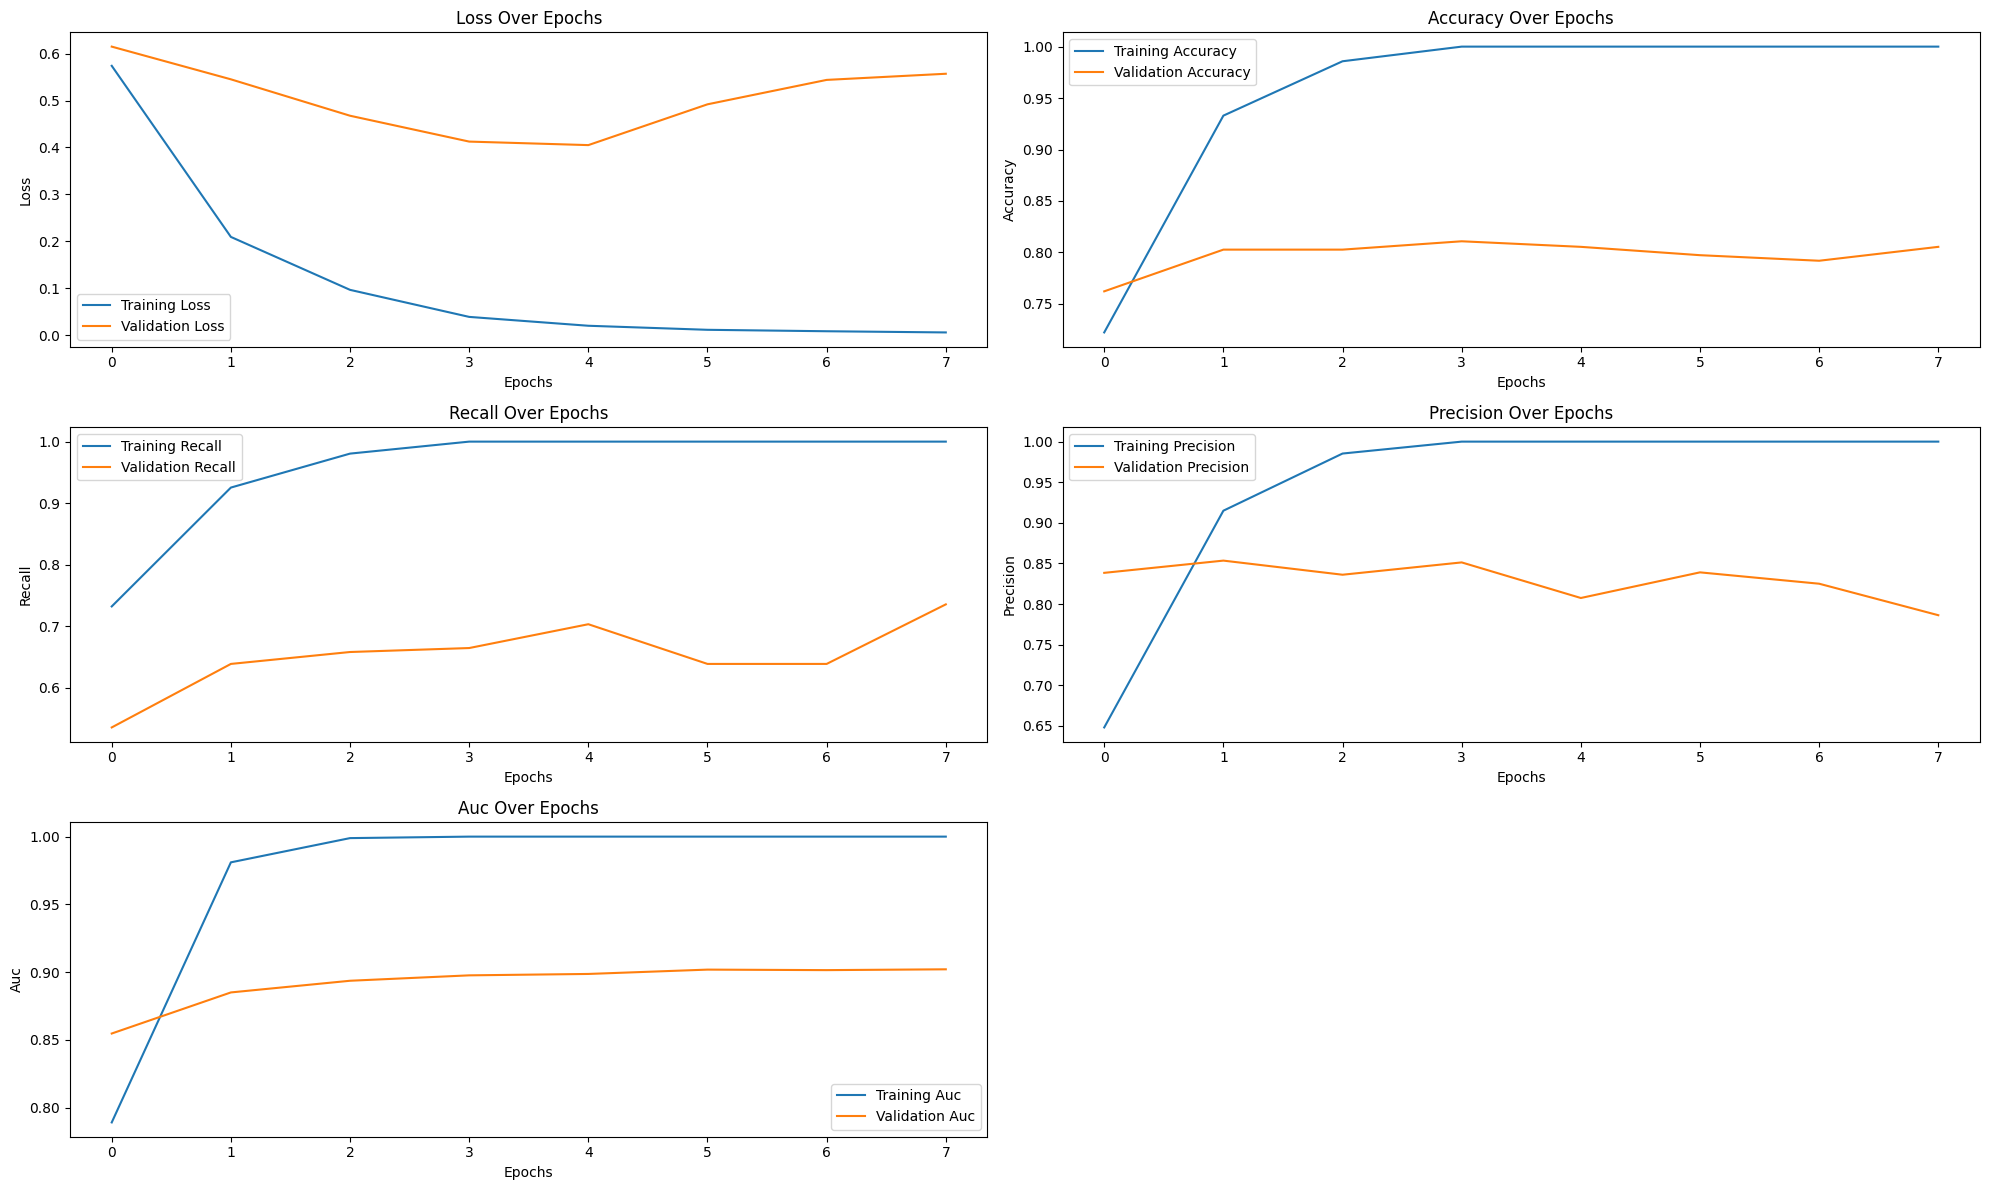


Final Training Loss: 0.0056
Final Validation Loss: 0.5572

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8054

Final Training Recall: 1.0000
Final Validation Recall: 0.7355

Final Training Precision: 1.0000
Final Validation Precision: 0.7862

Final Training Auc: 1.0000
Final Validation Auc: 0.9021


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - AUC: 0.8804 - accuracy: 0.8162 - loss: 0.4390 - precision: 0.8072 - recall: 0.7362
{'AUC': 0.88272625207901, 'accuracy': 0.8138527870178223, 'loss': 0.4327661395072937, 'precision': 0.8057143092155457, 'recall': 0.7305699586868286}
Test Loss: 0.4327661395072937
Test Accuracy: 0.8138527870178223
Test Recall: 0.7305699586868286
Test Precision: 0.8057143092155457
Test Auc: 0.88272625207901


In [18]:
### Two Layer Bidirectional LSTM with 64 neurons per layer and batch normalisation

model_lstm_emb_bidir_2 = deep_learning_utils.lstm_embeddings_creation(
    vectorize_layer=vectorize_layer,
    embedding_name='glove-wiki-gigaword-200',  # Pre-trained embedding name
    lstm_units=64,          # Number of neurons in the LSTM layer
    num_lstm_layers=2,      # Number of LSTM layers
    num_classes=1,          # Number of output classes
    seed=seed,                # Seed for reproducibility
    dropout_rate=0.0,       # No dropout
    l2_lambda=0,          # No L2 regularization
    metrics=metrics,   # Evaluation metrics
    batch_normalization=True,  # No batch normalization
    bidirectional=True
)

model_description = 'Bidirectional LSTM with pre-trained embeddings (wiki gigaword 200), 2 layers, 64 neurons, Batch Normalisation'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_emb_bidir_2,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )

### Bidirectional One Layer 32 neurons no regularisation - bigger embeddings (glove-wiki 300)

*** INITIALIZING MODEL TRAINING ***


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - AUC: 0.6243 - accuracy: 0.5815 - loss: 0.6538 - precision: 0.4875 - recall: 0.1625 - val_AUC: 0.8310 - val_accuracy: 0.7189 - val_loss: 0.5406 - val_precision: 0.8000 - val_recall: 0.4387
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - AUC: 0.8836 - accuracy: 0.8020 - loss: 0.4591 - precision: 0.8458 - recall: 0.6385 - val_AUC: 0.8855 - val_accuracy: 0.7676 - val_loss: 0.4652 - val_precision: 0.8632 - val_recall: 0.5290
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - AUC: 0.9394 - accuracy: 0.8758 - loss: 0.3312 - precision: 0.8779 - recall: 0.8138 - val_AUC: 0.8910 - val_accuracy: 0.7730 - val_loss: 0.4738 - val_precision: 0.8901 - val_recall: 0.5226
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - AUC: 0.9578 - accuracy: 0.8718 - loss: 0.2953 - precision: 0.9057 - recall: 0.7724 - val_AUC: 0.8957 - val_accuracy: 0.8297 - val_loss: 0.4055 - val_precision: 0.8239 - val_recall: 

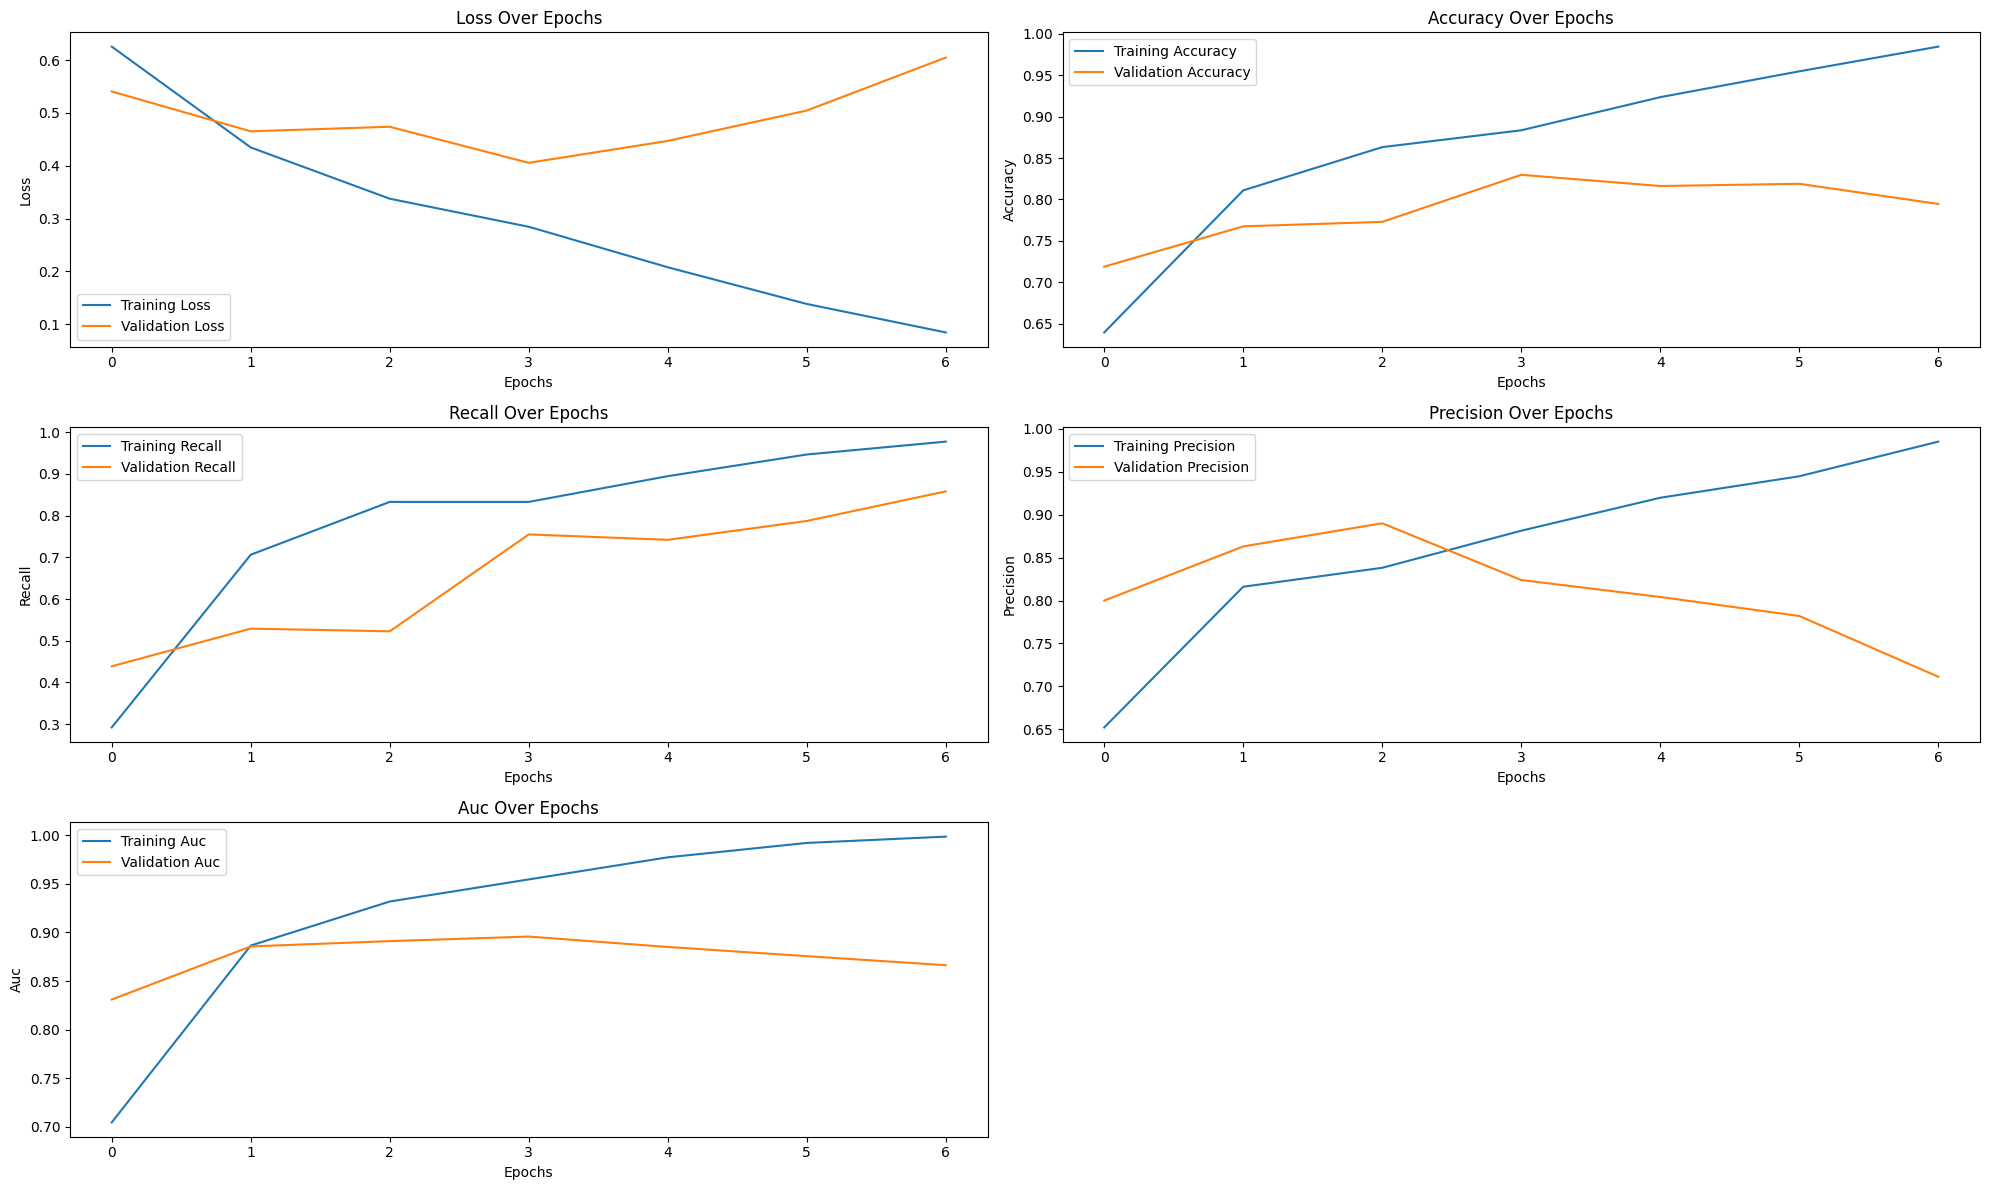


Final Training Loss: 0.0843
Final Validation Loss: 0.6048

Final Training Accuracy: 0.9844
Final Validation Accuracy: 0.7946

Final Training Recall: 0.9773
Final Validation Recall: 0.8581

Final Training Precision: 0.9853
Final Validation Precision: 0.7112

Final Training Auc: 0.9984
Final Validation Auc: 0.8662


*** EVALUATING MODEL ON TEST SET ***


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - AUC: 0.8803 - accuracy: 0.7992 - loss: 0.4345 - precision: 0.7369 - recall: 0.8105
{'AUC': 0.8813972473144531, 'accuracy': 0.8116883039474487, 'loss': 0.4310497045516968, 'precision': 0.7623762488365173, 'recall': 0.7979274392127991}
Test Loss: 0.4310497045516968
Test Accuracy: 0.8116883039474487
Test Recall: 0.7979274392127991
Test Precision: 0.7623762488365173
Test Auc: 0.8813972473144531


In [19]:
### Bidirectional One Layer 32 neurons no regularisation - bigger embeddings (glove-wiki 300)

model_lstm_emb_bidir_3 = deep_learning_utils.lstm_embeddings_creation(
    vectorize_layer=vectorize_layer,
    embedding_name='glove-wiki-gigaword-300',  # Pre-trained embedding name
    lstm_units=32,          # Number of neurons in the LSTM layer
    num_lstm_layers=1,      # Number of LSTM layers
    num_classes=1,          # Number of output classes
    seed=seed,                # Seed for reproducibility
    dropout_rate=0.0,       # No dropout
    l2_lambda=0,          # No L2 regularization
    metrics=metrics,   # Evaluation metrics
    batch_normalization=False,  # No batch normalization
    bidirectional=True
)

model_description = 'Bidirectional LSTM with pre-trained embeddings (wiki gigaword 300)'

model_registry = deep_learning_utils.train_plot_and_evaluate(model_lstm_emb_bidir_3,
                                            train_ds,
                                            val_ds,
                                            test_ds,
                                            epochs=epochs,
                                            strt_from_epoch=3,
                                            model_description=model_description,
                                            metrics=metrics,
                                            model_registry=model_registry,
                                            )